In [1]:
# Import libraries

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
np.random.seed(24)

In [3]:
def load_data():
    
    df = pd.read_csv("./kdd2004.csv")
    df["target"] = df["target"].map({-1:0,1:1})
    
    return df

It corresponds to the process of reducing the number of samples from the majority class until the balacing ratio is one (number of observation of the majority is the same as the minority).

Balacing ratio(X) =  X(Minority) / X(Majority)

Under-sampling can be random, or we remove the noisy observations, retains the observations inside a boundary or both the formers.

# Random Under-Sampling

Random Under-Sampling extract observations from the majority class until a certain balanced ratio is reached.

This approach is good in a way that it allows the algorithms to focus on both classes but it might remove important information for the majority class hence makes it harder for the algorithm to learn patterns that are useful to differenciate the two classes.


In [4]:
from imblearn.under_sampling import RandomUnderSampler

In [5]:
def make_class(sep):
    """Will create classes with different degrees of separateness."""

    X, y = make_classification(n_samples=1000,
                               n_features=2,
                               n_redundant=0,
                               n_classes=2,
                               n_clusters_per_class=1,
                               # The proportions of samples assigned to each class
                               weights=[0.99],
                               # How seperate the classes are
                               class_sep=sep,  
                               random_state=24,
                               )
    X = pd.DataFrame(X, columns=["varA", "varB"])

    y = pd.Series(y)

    return X, y

0    987
1     13
dtype: int64


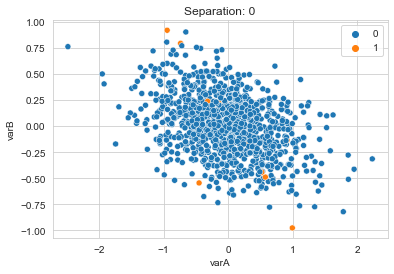

0    987
1     13
dtype: int64


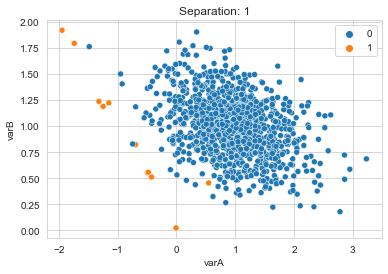

0    987
1     13
dtype: int64


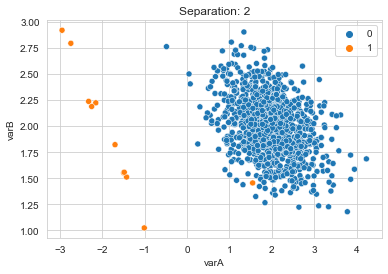

In [6]:
for sep in [0, 1, 2]:

    X, y = make_class(sep=sep)

    print(y.value_counts())

    sns.scatterplot(data=X, x="varA", y="varB", hue=y)
    
    plt.title(f"Separation: {sep}")
    plt.show()

In [7]:
X, y = make_class(sep=2)

rus = RandomUnderSampler(sampling_strategy='auto',
                         random_state=24,
                         replacement=False, # No replacement
                         )

X_resampled,y_resampled = rus.fit_resample(X,y)

In [8]:
X.shape,y.shape

((1000, 2), (1000,))

In [9]:
X_resampled.shape,y_resampled.shape

((26, 2), (26,))

In [10]:
y_resampled.value_counts()

0    13
1    13
dtype: int64

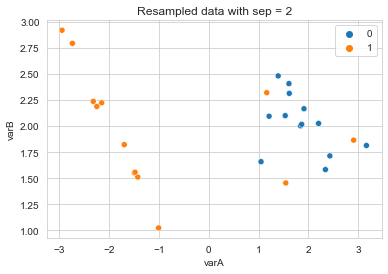

In [11]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled data with sep = 2")
plt.show()

In [12]:
df = load_data()

In [13]:
rus = RandomUnderSampler(sampling_strategy='auto',
                         random_state=24,
                         replacement=False, # No replacement
                         )

X_resampled,y_resampled = rus.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [14]:
df.shape

(145751, 75)

In [15]:
X_resampled.shape,y_resampled.shape

((2592, 74), (2592,))

In [16]:
print(f"Before resampling:")
print(f"{df['target'].value_counts()}")
print(f"After resampling:")
print(f"{y_resampled.value_counts()}")

Before resampling:
0    144455
1      1296
Name: target, dtype: int64
After resampling:
0    1296
1    1296
Name: target, dtype: int64


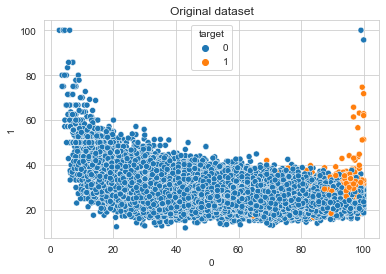

In [17]:
sns.scatterplot(data=df, x="0", y="1", hue="target")

plt.title(f"Original dataset")
plt.show()

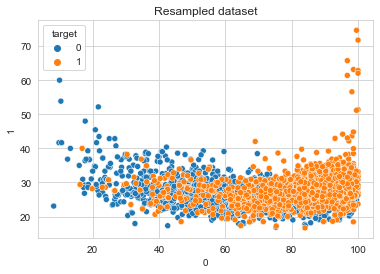

In [18]:
sns.scatterplot(data=X_resampled, x="0", y="1", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [19]:
def run_rf(X_train,X_test,y_train,y_test):
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=200,max_depth=4)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_test)[:,1]
    
    print(f"ROC-AUC for the train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=["target"],axis=1),df["target"],test_size=0.33, random_state=24)

In [21]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9761414267359368
ROC-AUC for the test set: 0.9640441514681941


In [22]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled,y_resampled,test_size=0.33, random_state=24)

In [23]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9945462026492528
ROC-AUC for the test set: 0.9833005786657932


There's an increase in performance!

In [24]:
rus = RandomUnderSampler(sampling_strategy='auto',
                         random_state=24,
                         replacement=True, # replacement
                         )

X_resampled,y_resampled = rus.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

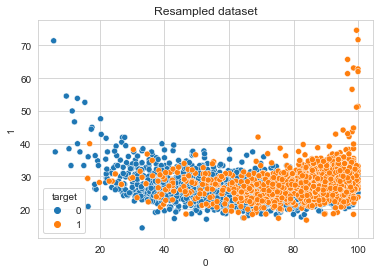

In [25]:
sns.scatterplot(data=X_resampled, x="0", y="1", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [26]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled,y_resampled,test_size=0.33, random_state=24)

In [27]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9948501499827453
ROC-AUC for the test set: 0.9842668413582267


Slightly better model with replacement...

# Condensed Nearest Neighbours 

Extract observations at the boudary between the two, or more, classes.

It's a cleaning method that will change the final shape of the dataset, and the boundary of the classes matters.

It works as follow:
* Separate the minority class to the majority class.
* Add at random one instance of the majority class to the minority class.
* Train a 1-KNN algorithm.
* Use this KNN to make a prediction on one instance at a time on the majority class. If the instance belongs to the majority class, we can ignore this observation. If the prediction doesn't match the class, then we pass this observation to the minority group.
* After having one more observation, we train again a 1-KNN of the minority class + two observation from the majority class.
* Repeat step 4-5 until we have examined all the observations from the majority class and decided if they do belong in the dataset or not.

This dataset will be used to train the algorithm. It focuses on harder to differenciate observations between the two classes, but will introduce also noise in the dataset.

For the multi-class undersampling, it uses a One vs the Rest strategy.

In [32]:
from imblearn.under_sampling import CondensedNearestNeighbour

In [33]:
cnn = CondensedNearestNeighbour(sampling_strategy='auto',
                                random_state=24,
                                n_neighbors=None,
                                n_seeds_S=1,
                                n_jobs=-1,
                                )

In [34]:
X, y = make_class(sep=2)

X_resampled,y_resampled = cnn.fit_resample(X,y)

In [39]:
X.shape,y.shape,X_resampled.shape,y_resampled.shape

((1000, 2), (1000,), (38, 2), (38,))

In [40]:
y.value_counts(),y_resampled.value_counts()

(0    987
 1     13
 dtype: int64,
 0    25
 1    13
 dtype: int64)

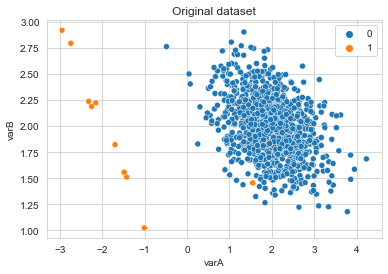

In [38]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

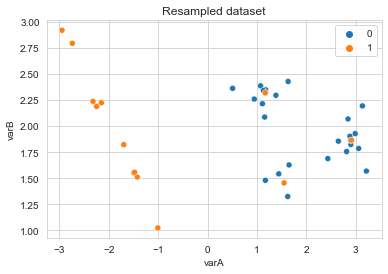

In [36]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

The remaining points from the majority class are the points that are most likely to be misclassified. 

In [44]:
df = df.sample(frac=1).reset_index(drop=True)

In [61]:
X_resampled,y_resampled = cnn.fit_resample(df.drop(labels=["target"],axis=1)[:10000],df["target"][:10000])

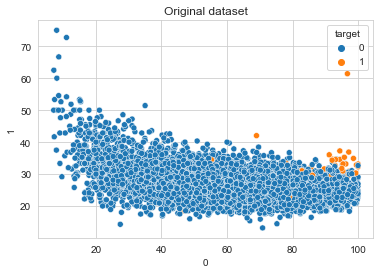

In [46]:
sns.scatterplot(data=df.drop(labels=["target"],axis=1)[:10000], x="0", y="1", hue=df["target"][:10000])

plt.title(f"Original dataset")
plt.show()

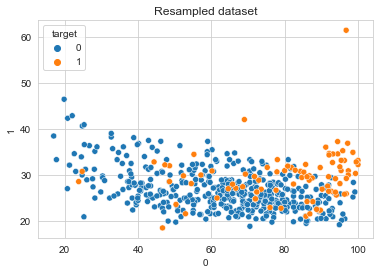

In [47]:
sns.scatterplot(data=X_resampled, x="0", y="1", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [62]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1)[:10000], df["target"][:10000], test_size=0.33, random_state=24)

In [63]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9967060020396119
ROC-AUC for the test set: 0.9827205757544895


In [64]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [65]:
run_rf(X_train_resampled, X_test_resampled,
       y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9984242424242423
ROC-AUC for the test set: 0.9593134138588684


# Tomek links

If two samples are nearest neighbours and from two different classes, therefore they are tomek links.

It is a cleaning method that will remove samples from the dataset where the boundary matters.

We can choose to keep only the minority class of the tomek links by using sample_strategy="auto" or we remove all the tomek links by using sample_strategy="all".

This method removes noise hence improving the performance of the model but on the downside, it might make the model missclassified the hard cases to classify.

For the multi-class, it uses One vs Rest approach.

In [66]:
from imblearn.under_sampling import TomekLinks

In [67]:
tl = TomekLinks(sampling_strategy='auto', n_jobs=-1)

In [68]:
X, y = make_class(sep=2)

X_resampled,y_resampled = tl.fit_resample(X,y)

In [70]:
X.shape,y.shape,X_resampled.shape,y_resampled.shape

((1000, 2), (1000,), (998, 2), (998,))

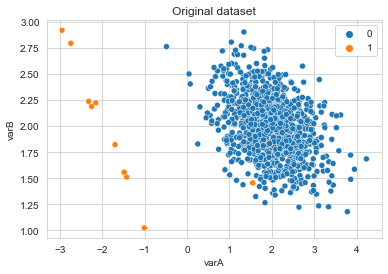

In [71]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

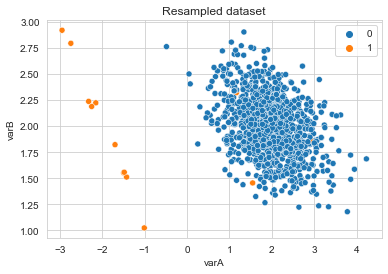

In [72]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [73]:
X_resampled,y_resampled = tl.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [79]:
df.shape,X_resampled.shape

((145751, 75), (145629, 74))

In [82]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 122


In [74]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [75]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9776447878644714
ROC-AUC for the test set: 0.9683504889634986


In [76]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [77]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9759280716107235
ROC-AUC for the test set: 0.9672284250660472


Not so much improvement...

# One Sided Selection

This method combines both Condensed Nearest Neighbours and Tomek Links.

First it selects instances at the boundary of the class with a CNN then remove the tomek links.

It claims to focus only on harder cases by selecting those at the boundary, while removing noise at the boundary with tomek links.

For multi-class, it uses the One vs Rest method.

In [83]:
from imblearn.under_sampling import OneSidedSelection

In [84]:
oss = OneSidedSelection(sampling_strategy='auto',
                        random_state=24,
                        n_neighbors=None,
                        n_seeds_S=1,
                        n_jobs=-1,
                        )

In [85]:
X,y = make_class(sep=2)

In [87]:
X_resampled,y_resampled = oss.fit_resample(X,y)

In [95]:
X.shape,X_resampled.shape

((1000, 2), (145511, 74))

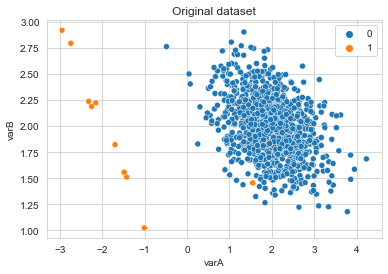

In [88]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

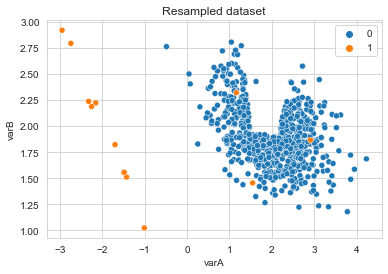

In [89]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [90]:
X_resampled,y_resampled = oss.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [96]:
df.shape,X_resampled.shape

((145751, 75), (145511, 74))

In [97]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 240


More observation removed than with the tomek links.

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [92]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9748904787911965
ROC-AUC for the test set: 0.9674956622441397


In [93]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [94]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9768327257342753
ROC-AUC for the test set: 0.97105315784657


There is an improvement on the model's performance (less overfitting).

# Edited Nearest Neighbours

This method removes samples which neighbours disagree on the class and look at each 3 neighbours that the observations is being evaluating.

It is a cleaning under-sampling method and removes the harder cases to class.

It works as follow:
* Train 3 KNN
* Finds each observation's 3 neighbours
* Decide wether or not to keep the observation based on the neighbours agreement with its class:
    * All neighbours agree
    * Most neighbours agree
    * 1 pass over the data
    
For multi-class classification, this algorithm uses One vs Rest method.

In practice, samples from the majority classes that are too close to the minority class are removed.

In [98]:
from imblearn.under_sampling import EditedNearestNeighbours

In [99]:
# If 'all', all neighbours will have to agree with the samples of interest to not be excluded.
# If 'mode', the majority vote of the neighbours will be used in order to exclude a sample.
ENN = EditedNearestNeighbours(sampling_strategy='auto',
                              n_neighbors=3,
                              kind_sel='all',
                              n_jobs=-1,
                              )

In [103]:
X,y = make_class(sep=2)

In [104]:
X_resampled,y_resampled = ENN.fit_resample(X,y)

In [106]:
X.shape,X_resampled.shape

((1000, 2), (990, 2))

Removed 10 observations...

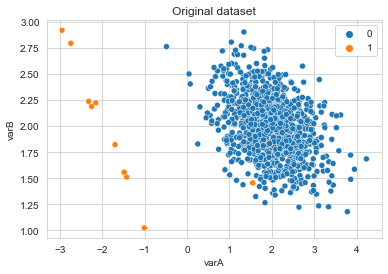

In [107]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

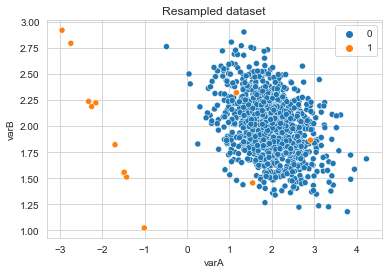

In [108]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [109]:
X_resampled,y_resampled = ENN.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [110]:
df.shape,X_resampled.shape

((145751, 75), (144643, 74))

In [111]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 1108


In [112]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [113]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9783915519670251
ROC-AUC for the test set: 0.970697169744752


In [114]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [115]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9743596580344156
ROC-AUC for the test set: 0.9675600225632126


Not so much improvement...

# Repeted Edited Nearest Neighbours

This method removes samples which neighbours disagree on the class and look at each 3 neighbours that the observations is being evaluating.

It is a cleaning under-sampling method and removes the harder cases to class.

It works as follow:
* Train 3 KNN
* Finds each observation's 3 neighbours
* Decide wether or not to keep the observation based on the neighbours agreement with its class:
    * All neighbours agree
    * Most neighbours agree
    * 1 pass over the data
* Repeats
    * Until no more observations are removed
    * A maximum number of cycles is reached

This method removes more observation than the Edited Nearest Neighbours with various passes over the dataset and the same number of neighbours.
    
For multi-class classification, this algorithm uses One vs Rest method.

In practice, samples from the majority classes that are too close to the minority class are removed.

In [116]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

In [117]:
X, y = make_class(sep=2)

renn = RepeatedEditedNearestNeighbours(sampling_strategy='auto',
                                       n_neighbors=3,
                                       max_iter=100,
                                       kind_sel='all',
                                       n_jobs=-1,
                                       )

X_resampled,y_resampled = renn.fit_resample(X,y)

In [118]:
X.shape,X_resampled.shape

((1000, 2), (987, 2))

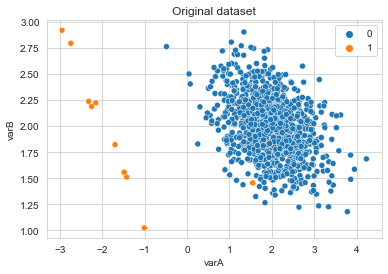

In [119]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

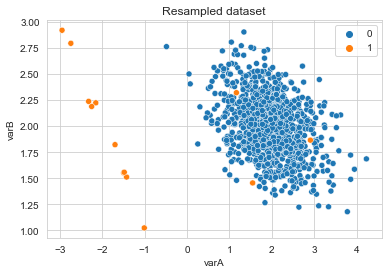

In [120]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [121]:
X_resampled,y_resampled = renn.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [122]:
df.shape,X_resampled.shape

((145751, 75), (144535, 74))

In [123]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 1216


In [124]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [125]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9776339490107876
ROC-AUC for the test set: 0.9681284648672077


In [126]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [127]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9748750424632577
ROC-AUC for the test set: 0.9716807373123322


Little improvement (less overfitting) from the model.

# All KNN

This method removes samples which neighbours disagree on the class and look at each 3 neighbours that the observations is being evaluating.

It is a cleaning under-sampling method and removes the harder cases to class.

It works as follow:
* Train 3 KNN
* Finds each observation's 3 neighbours
* Decide wether or not to keep the observation based on the neighbours agreement with its class:
    * All neighbours agree
    * Most neighbours agree
    * 1 pass over the data
* Repeats by addind 1 to the KNN
    * Until no more observations are removed
    * A maximum number of cycles is reached

This method removes more observation than the Edited Nearest Neighbours with various passes over the dataset and the same number of neighbours, and the successive KNNs have more and more neighbours making it more stringent with more observations needed to agree on a specific class.
    
For multi-class classification, this algorithm uses One vs Rest method.

In practice, samples from the majority classes that are too close to the minority class are removed.

In [128]:
from imblearn.under_sampling import AllKNN

In [134]:
X, y = make_class(sep=2)

allknn = AllKNN(sampling_strategy='auto',
              n_neighbors=3, # The number of neighbours with start with.
              kind_sel='all', 
              n_jobs=-1,
              )

X_resampled, y_resampled = allknn.fit_resample(X, y)

In [135]:
X.shape,X_resampled.shape

((1000, 2), (987, 2))

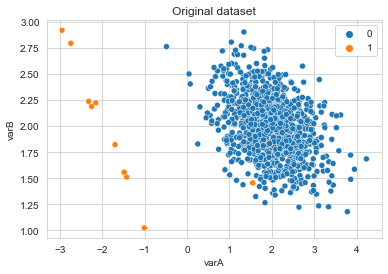

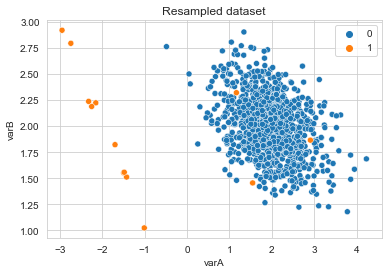

In [136]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [137]:
X_resampled,y_resampled = allknn.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [138]:
df.shape,X_resampled.shape

((145751, 75), (144578, 74))

In [139]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 1173


In [140]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [141]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9773786775484056
ROC-AUC for the test set: 0.9673565231202551


In [142]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [143]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9767265242193435
ROC-AUC for the test set: 0.9695696762245865


No improvement...

# Neighbourhood Cleaning Rules

This method combines ENN + 3KNN only on neighbours of the minority class.

It is a cleaning under-sampling method and removes the harder cases to class.

It works as follow:
* Remove noisy observation from the majority class using a ENN with a 3KNN
* Remove observation from the majority class close to the boundary with a 1KNN
* Train 3 KNN on the whole dataset
* Finds each observation's 3 neighbours on the majority class
* Decide wether or not to keep the observation based on the neighbours agreement with its class:
    * All neighbours agree
    * Most neighbours agree
    * 1 pass over the data
* Train a 1KNN and remove observation from the majority class that are missclassified by the 1KNN.

Only removes neighbour if neighbour's proportion class is at least half of the observation of the minority class. This is done to avoid to remove other classes with fewer observation.

For multi-class classification, this algorithm uses One vs Rest method.

In practice, samples from the majority classes that are too close to the minority class are removed.

In [129]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

In [144]:
X, y = make_class(sep=2)

ncr = NeighbourhoodCleaningRule(sampling_strategy='auto',
                                # The number of neighbours with start with.
                                n_neighbors=3,
                                kind_sel='all',
                                # Threshold used to whether consider a class or not during the cleaning after applying ENN.
                                threshold_cleaning=0.5,
                                n_jobs=-1,
                                )

X_resampled, y_resampled = ncr.fit_resample(X, y)

In [145]:
X.shape,X_resampled.shape

((1000, 2), (991, 2))

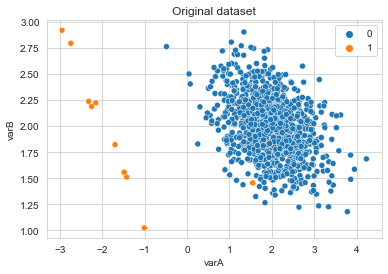

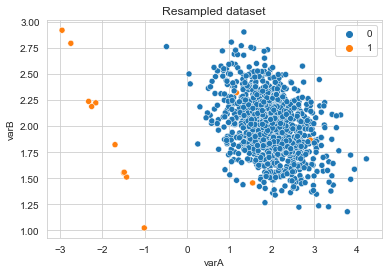

In [146]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [148]:
X_resampled,y_resampled = ncr.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [149]:
df.shape,X_resampled.shape

((145751, 75), (143805, 74))

In [150]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 1946


In [151]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [152]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.976009231881945
ROC-AUC for the test set: 0.9681176013028632


In [153]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [154]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9734664299972295
ROC-AUC for the test set: 0.9652706073506805


No improvements...

# Near Miss

NearMiss is a fixed method that will return a final dataset with a number of observations being equal to two times the number of observation of the minority class, and it retains information closer to the minority class.

It was design to work with text where each word is a complex representation of words and tags.

3 different versions.

V1:
* Determine the mean distance to each k closest neighbour from X minority.
* Retains observations from X majority with the smallest average distance.

**Select observations closer to the closest minority class.**

V2:
* Determine the mean distance to each k furthest neighbour from X minority.
* Retains observations from X majority with the smallest average distance.

**Select observations closer to the farthest minority class.**


V3:
* Retains the 3 closest K from the minority -- > intermediare dataset.
* Then select X majority which average distance to X min is the largest.

**Select observations furthest to their nearest neighbours.**

For multi-class classification, it uses One vs Rest.

In [130]:
from imblearn.under_sampling import NearMiss

In [155]:
X, y = make_class(sep=2)

nm = NearMiss(sampling_strategy='auto',
              version=1, #version 1, 2 or 3
              n_neighbors=3,
              # parameter correspond to the number of neighbours selected
              # create the subset in which the selection will be performed
              n_neighbors_ver3=3,
              n_jobs=-1,
              )

X_resampled, y_resampled = nm.fit_resample(X, y)

In [156]:
X.shape,X_resampled.shape

((1000, 2), (26, 2))

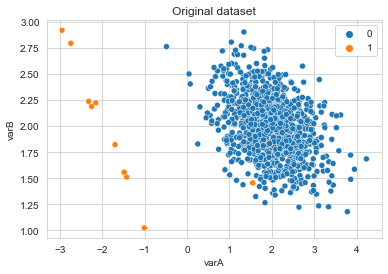

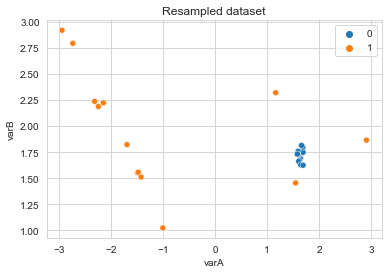

In [157]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

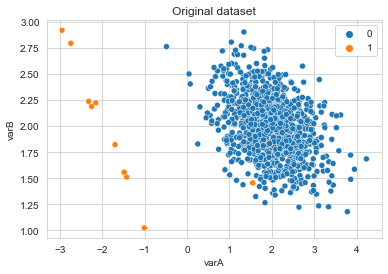

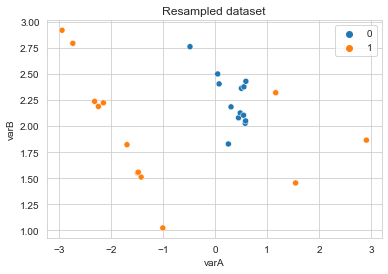

In [166]:
X, y = make_class(sep=2)

nm = NearMiss(sampling_strategy='auto',
              version=2, #version 1, 2 or 3
              n_neighbors=3,
              # parameter correspond to the number of neighbours selected
              # create the subset in which the selection will be performed
              n_neighbors_ver3=3,
              n_jobs=-1,
              )

X_resampled, y_resampled = nm.fit_resample(X, y)
X.shape,X_resampled.shape

sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

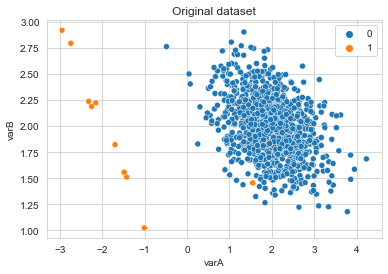

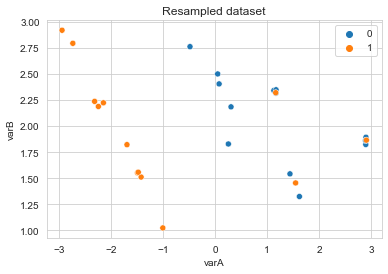

In [167]:
X, y = make_class(sep=2)

nm = NearMiss(sampling_strategy='auto',
              version=3, #version 1, 2 or 3
              n_neighbors=3,
              # parameter correspond to the number of neighbours selected
              # create the subset in which the selection will be performed
              n_neighbors_ver3=3,
              n_jobs=-1,
              )

X_resampled, y_resampled = nm.fit_resample(X, y)
X.shape,X_resampled.shape

sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [158]:
X_resampled,y_resampled = nm.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [159]:
df.shape,X_resampled.shape

((145751, 75), (2592, 74))

In [160]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 143159


In [162]:
X_train, X_test, b_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [163]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9774650298257744
ROC-AUC for the test set: 0.9666607772065521


In [164]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [165]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9966658702981073
ROC-AUC for the test set: 0.9893547330494594


Better performance!

# Insteance Hardness Threshold

The probability of an observation being miss-classified. The smaller the probability of a class, the higher the chance that this observation being miss-classified.

it works as follow:
* Train a classifier.
* Determine the probability of each observation of the majority class.
* Find the threshold (percentile = (1 - (nXmin / nXmaj) * 100).
* Select observations where probability > threshold.

In [ ]:
from imblearn.under_sampling import InstanceHardnessThreshold

In [173]:
X, y = make_class(sep=2)

iht = InstanceHardnessThreshold(sampling_strategy='auto',
                               estimator=None, #Default will be RF
                               random_state=None,
                               cv=5,
                               n_jobs=-1,
                               )

X_resampled, y_resampled = iht.fit_resample(X, y)

In [174]:
X.shape,X_resampled.shape

((1000, 2), (936, 2))

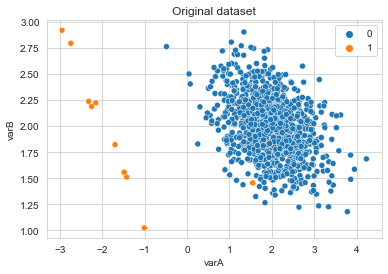

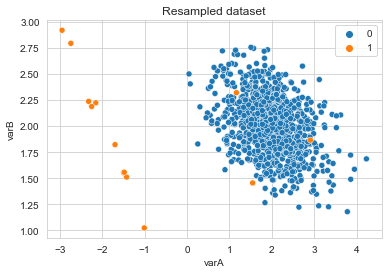

In [175]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [180]:
removed_obs = [0 if x in iht.sample_indices_ else 1 for x in X.index]

len(removed_obs),np.mean(removed_obs)

(1000, 0.064)

6.4% instances removed...

In [181]:
X_resampled,y_resampled = iht.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [182]:
df.shape,X_resampled.shape

((145751, 75), (126831, 74))

In [183]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 18920


In [184]:
X_train, X_test, b_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [185]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9780727403699783
ROC-AUC for the test set: 0.9672098398544644


In [186]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [187]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9845420010582115
ROC-AUC for the test set: 0.9837597111902124


Improvements!

# SUM-UP

To be filled...